In [14]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
_rng = np.random.default_rng(12345)

In [18]:
def _random_tree(nb_nodes: int, p: float=0.5, directed=True):
  mat = np.zeros((nb_nodes, nb_nodes))
  highest_node = 0
  def _continue_random_tree(i: int):
    nonlocal highest_node
    if highest_node + 1 >= nb_nodes:
      return

    mat[i, highest_node + 1] = 1
    highest_node += 1
    visit_next = highest_node
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      print(i, highest_node + 1)
      highest_node += 1
      _continue_random_tree(highest_node)
    _continue_random_tree(visit_next)

  _continue_random_tree(0)

  if not directed: # This might disconnect the graph
    mat *= np.transpose(mat)

  return mat

In [ ]:
import collections


def _random_tree(nb_nodes: int, p: float=0.5, directed=True):
  mat = np.zeros((nb_nodes, nb_nodes))
  highest_node = 0
  nodes_queue = collections.deque([0])
  while nodes_queue:
    i = nodes_queue.pop()
    mat[i, highest_node + 1] = 1
    highest_node += 1
    nodes_queue.appendleft(highest_node)
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      print(i, highest_node + 1)
      highest_node += 1
      nodes_queue.appendleft(highest_node)

  def _continue_random_tree(i: int):
    nonlocal highest_node
    if highest_node + 1 >= nb_nodes:
      return

    mat[i, highest_node + 1] = 1
    highest_node += 1
    visit_next = highest_node
    if highest_node + 1 < nb_nodes and _rng.uniform() < p:
      mat[i, highest_node + 1] = 1
      print(i, highest_node + 1)
      highest_node += 1
      _continue_random_tree(highest_node)
    _continue_random_tree(visit_next)

  _continue_random_tree(0)

  if not directed: # This might disconnect the graph
    mat *= np.transpose(mat)

  return mat

In [22]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, # labels=[str(i) for i in range(adjacency_matrix.shape[0])],
            with_labels=True)
    plt.show()

0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30


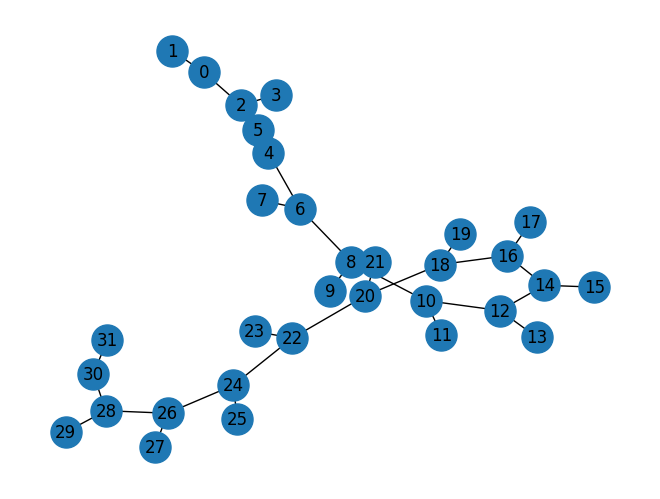

In [29]:
adj = _random_tree(32, 1)
show_graph_with_labels(adj)

TypeError: show_graph_with_labels() missing 1 required positional argument: 'adjacency_matrix'